<a href="https://colab.research.google.com/github/krshirkoohi/background-checks/blob/main/BackgroundChecks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scenario

The recruitment team completes background checks every month to surface criminal records of candidates before they move to the interview round. They want to understand how many candidates failed the background check over the last year, and if there are any trends. They also want to learn how many background checks are completed each month and if there are any trends visible in the data. We are tasked with preparing a slide that summarises the findings which can be imported to a PowerPoint presentation.

Using SQL, we extract three tables from the primary dataset. Table 1 gives an overview of all failed checks in the last year. Table 2 lists the number of checks completed in every given month in the previous year. Table 3 provides location data for the candidates.

# Solution

## Initialisation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql

## Data Import

In [ ]:
table1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/_Archive/AlphaSierra Data/Failed Background Checks.csv")
table2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/_Archive/AlphaSierra Data/Total Background Checks Actioned.csv")
table3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/_Archive/AlphaSierra Data/Actioner Locations.csv")

In [ ]:
table1

,id,advisor_id,state,actioner_id,taken_at
0,1,78272,FAILED,1,11/10/2022 2:59:59
1,2,21516,FAILED,9,1/30/2022 23:41:46
2,3,94273,FAILED,2,9/19/2022 3:44:45
3,4,40423,FAILED,1,2/14/2022 10:41:12
4,5,16277,FAILED,2,5/11/2022 9:55:22
...,...,...,...,...,...
992,993,98172,FAILED,8,3/10/2022 13:21:37
993,994,12312,FAILED,3,1/14/2022 16:39:24
994,995,72532,FAILED,2,1/5/2022 3:41:10
995,996,35492,FAILED,7,2/10/2022 14:06:28


In [ ]:
table2

,month_year,total
0,January 2022,1132
1,February 2022,1166
2,March 2022,1198
3,April 2022,1203
4,May 2022,1178
5,June 2022,1182
6,July 2022,1203
7,August 2022,1223
8,September 2022,1195
9,October 2022,1210


In [ ]:
table3

,Actioner IDs,Location
0,1,New York
1,2,Hamburg
2,3,London
3,4,Shanghai
4,5,San Francisco
5,6,Dubai
6,7,Hong Kong
7,8,Seoul
8,9,Tokyo


Load the data into a SQLite database.

In [ ]:
conn = sql.connect('AlphaSierra.db')
table1.to_sql('table1',conn)
table2.to_sql('table2',conn)
table3.to_sql('table3',conn)

9

## Data Wrangling

### SQL to DataFrame

In [ ]:
failed_df = pd.read_sql('SELECT "actioner_id", "taken_at" FROM table1', conn)
month_df = pd.read_sql('SELECT "month_year", "total" FROM table2', conn)
location_df = pd.read_sql('SELECT "Actioner IDs" AS "actioner_id", "Location" FROM table3', conn)

In [ ]:
failed_df

,actioner_id,taken_at
0,1,11/10/2022 2:59:59
1,9,1/30/2022 23:41:46
2,2,9/19/2022 3:44:45
3,1,2/14/2022 10:41:12
4,2,5/11/2022 9:55:22
...,...,...
992,8,3/10/2022 13:21:37
993,3,1/14/2022 16:39:24
994,2,1/5/2022 3:41:10
995,7,2/10/2022 14:06:28


In [ ]:
month_df

,month_year,total
0,January 2022,1132
1,February 2022,1166
2,March 2022,1198
3,April 2022,1203
4,May 2022,1178
5,June 2022,1182
6,July 2022,1203
7,August 2022,1223
8,September 2022,1195
9,October 2022,1210


In [ ]:
location_df

,actioner_id,Location
0,1,New York
1,2,Hamburg
2,3,London
3,4,Shanghai
4,5,San Francisco
5,6,Dubai
6,7,Hong Kong
7,8,Seoul
8,9,Tokyo


Remove dependency on **table3** by joining **location_df** to **failed_df** on **actioner_id**.

In [ ]:
failed_df = failed_df.merge(location_df, on='actioner_id', how='left').drop('actioner_id', axis = 1)
failed_df

,taken_at,Location
0,11/10/2022 2:59:59,New York
1,1/30/2022 23:41:46,Tokyo
2,9/19/2022 3:44:45,Hamburg
3,2/14/2022 10:41:12,New York
4,5/11/2022 9:55:22,Hamburg
...,...,...
992,3/10/2022 13:21:37,Seoul
993,1/14/2022 16:39:24,London
994,1/5/2022 3:41:10,Hamburg
995,2/10/2022 14:06:28,Hong Kong


Make dates consistent in **table1** and **table2**.

In [ ]:
failed_df['taken_at'] = pd.to_datetime(failed_df['taken_at']).dt.to_period('M')
failed_df.rename(columns={"taken_at":"month_year"},inplace=True)
failed_df

,month_year,Location
0,2022-11,New York
1,2022-01,Tokyo
2,2022-09,Hamburg
3,2022-02,New York
4,2022-05,Hamburg
...,...,...
992,2022-03,Seoul
993,2022-01,London
994,2022-01,Hamburg
995,2022-02,Hong Kong


In [ ]:
month_df['month_year'] = pd.to_datetime(month_df['month_year']).dt.to_period('M')
month_df

,month_year,total
0,2022-01,1132
1,2022-02,1166
2,2022-03,1198
3,2022-04,1203
4,2022-05,1178
5,2022-06,1182
6,2022-07,1203
7,2022-08,1223
8,2022-09,1195
9,2022-10,1210


## Data Exploration

### Fails per Month

In [ ]:
fpm = failed_df.groupby(failed_df['month_year'], axis = 0, as_index = False).count().rename(columns={"Location":"count"})
fpm

,month_year,count
0,2022-01,83
1,2022-02,75
2,2022-03,93
3,2022-04,77
4,2022-05,89
5,2022-06,74
6,2022-07,97
7,2022-08,89
8,2022-09,87
9,2022-10,77


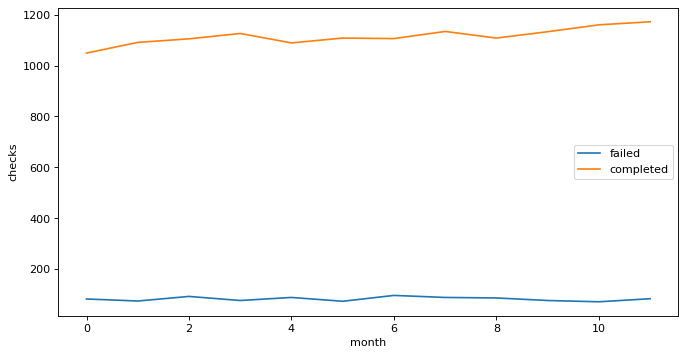

In [ ]:
plt.figure(figsize=(10,5), dpi=80)
plt.plot(fpm.index,fpm['count'], label = "failed")
plt.plot(month_df.index,month_df['total']-fpm['count'], label = "completed")
plt.ylabel('checks')
plt.xlabel('month')
plt.legend()




<Figure size 400x400 with 0 Axes>

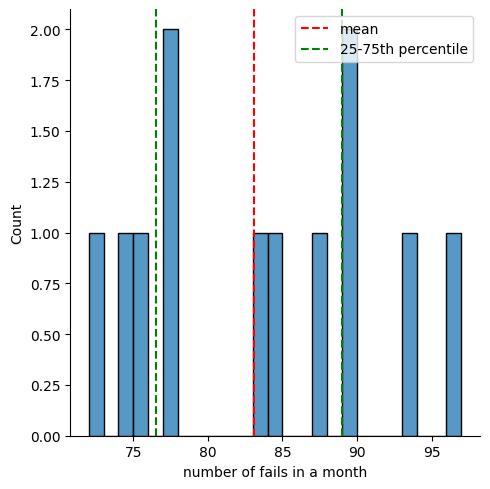

In [ ]:
plt.figure(figsize=(5,5), dpi=80)
sns.displot(fpm['count'], bins=(max(fpm['count']) - min(fpm['count'])))
plt.axvline(x=np.mean(fpm['count']), c='red',ls='--',label = 'mean')
plt.axvline(x=np.percentile(fpm['count'],25),c='green',ls='--', label = '25-75th percentile')
plt.axvline(x=np.percentile(fpm['count'],75),c='green',ls='--')
plt.xlabel('number of fails in a month')
plt.legend()

<Figure size 400x400 with 0 Axes>

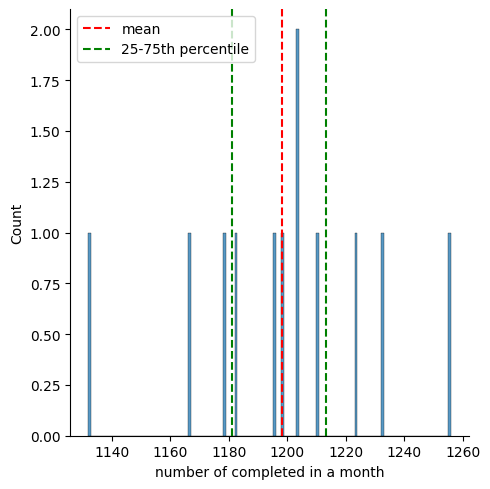

In [ ]:
plt.figure(figsize=(5,5), dpi=80)
completed = month_df['total']#-fpm['count']
sns.displot(completed, bins=(max(completed) - min(completed)))
plt.axvline(x=np.mean(completed), c='red',ls='--',label = 'mean')
plt.axvline(x=np.percentile(completed,25),c='green',ls='--', label = '25-75th percentile')
plt.axvline(x=np.percentile(completed,75),c='green',ls='--')
plt.xlabel('number of completed in a month')
plt.legend()

<Axes: title={'center': 'distribution of completed checks'}, ylabel='completed'>

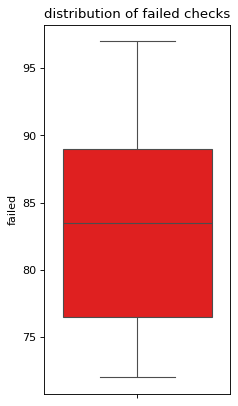

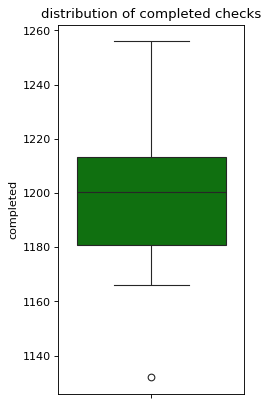

In [ ]:
plt.figure(figsize=(3,6), dpi=80); plt.ylabel('failed'); plt.title('distribution of failed checks')
sns.boxplot(fpm['count'], color='r');
plt.figure(figsize=(3,6), dpi=80); plt.ylabel('completed'); plt.title('distribution of completed checks')
sns.boxplot(completed, color='g')

In [ ]:
fpm['success'] = fpm['count'] + month_df['total']
fpm['fail_rate'] = fpm['count'] / fpm['success']
fpm.rename(columns={"count":"fails"})
fpm

,month_year,count,success,fail_rate
0,2022-01,83,1215,0.068313
1,2022-02,75,1241,0.060435
2,2022-03,93,1291,0.072037
3,2022-04,77,1280,0.060156
4,2022-05,89,1267,0.070245
5,2022-06,74,1256,0.058917
6,2022-07,97,1300,0.074615
7,2022-08,89,1312,0.067835
8,2022-09,87,1282,0.067863
9,2022-10,77,1287,0.059829


In [ ]:
max(fpm['fail_rate'])

0.07461538461538461

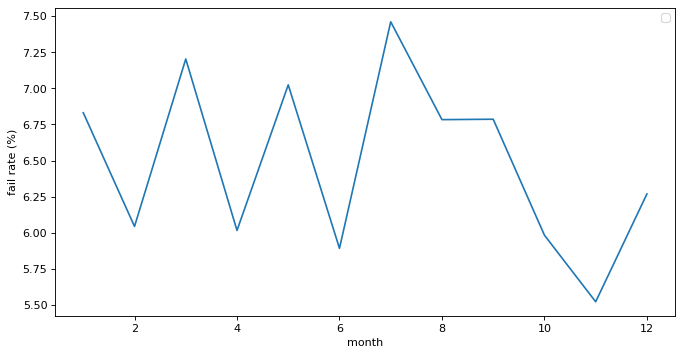

In [ ]:
plt.figure(figsize=(10,5), dpi=80)
plt.plot(fpm.index+1,fpm['fail_rate']*100)
plt.ylabel('fail rate (%)')
plt.xlabel('month')
plt.legend()


In [ ]:
fpm.describe()

,count
count,12.000000
mean,83.083333
std,8.106769
min,72.000000
25%,76.500000
50%,83.500000
75%,89.000000
max,97.000000


from matplotlib import pyplot as plt
_df_4['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

### Fails per City

In [ ]:
fpc = failed_df.groupby(failed_df['Location'], axis = 0, as_index = False).count().rename(columns={"month_year":"count"})
fpc

,Location,count
0,Dubai,101
1,Hamburg,122
2,Hong Kong,121
3,London,104
4,New York,131
5,San Francisco,102
6,Seoul,123
7,Shanghai,102
8,Tokyo,91


Add 2022 population census to fpc.

In [ ]:
pop = pd.DataFrame(
    [["Dubai",2964000],
    ["Hamburg",1788000],
    ["Hong Kong",2964000],
    ["London",8799800],
    ["New York",8335897],
    ["San Francisco",834000],
    ["Seoul",9976000],
    ["Shanghai",28517000],
    ["Tokyo",37274000]],
    columns=['Location','pop']
)
pop

,Location,pop
0,Dubai,2964000
1,Hamburg,1788000
2,Hong Kong,2964000
3,London,8799800
4,New York,8335897
5,San Francisco,834000
6,Seoul,9976000
7,Shanghai,28517000
8,Tokyo,37274000


In [ ]:
fpc = fpc.merge(pop,how='left',on='Location')
fpc

,Location,count,pop
0,Dubai,101,2964000
1,Hamburg,122,1788000
2,Hong Kong,121,2964000
3,London,104,8799800
4,New York,131,8335897
5,San Francisco,102,834000
6,Seoul,123,9976000
7,Shanghai,102,28517000
8,Tokyo,91,37274000


We don't know the number of successful checks per country. We can only make a proportional estimate of fail % against the general population.

In [ ]:
#fpc['fail_pct'] = fpc['count'] / fpc['pop'] * 100
fpc['fail_pct'] = fpc['count'] / sum(fpc['count'])
fpc

,Location,count,pop,fail_pct
0,Dubai,101,2964000,0.101304
1,Hamburg,122,1788000,0.122367
2,Hong Kong,121,2964000,0.121364
3,London,104,8799800,0.104313
4,New York,131,8335897,0.131394
5,San Francisco,102,834000,0.102307
6,Seoul,123,9976000,0.123370
7,Shanghai,102,28517000,0.102307
8,Tokyo,91,37274000,0.091274


Plot **fail_pct** on a map.

In [ ]:
geo_data = {
    'Dubai': [25.2048, 55.2708],
    'Hamburg': [53.5503, 10.0003],
    'Hong Kong': [22.2783, 114.1747],
    'London': [51.5074, -0.1278],
    'New York': [40.7128, -74.0060],
    'San Francisco': [37.7749, -122.4194],
    'Seoul': [37.5665, 126.9780],
    'Shanghai': [31.2304, 121.4737],
    'Tokyo': [35.6895, 139.6917]
}
geo_df = pd.DataFrame.from_dict(geo_data, orient='index', columns=['Latitude', 'Longitude'])
#geo_df.index.rename('Location', inplace=True)
geo_df = geo_df.reset_index().rename(columns={'index':'Location'})
geo_df

,Location,Latitude,Longitude
0,Dubai,25.2048,55.2708
1,Hamburg,53.5503,10.0003
2,Hong Kong,22.2783,114.1747
3,London,51.5074,-0.1278
4,New York,40.7128,-74.0060
5,San Francisco,37.7749,-122.4194
6,Seoul,37.5665,126.9780
7,Shanghai,31.2304,121.4737
8,Tokyo,35.6895,139.6917


<ipython-input-304-982536aea151>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


Text(155.59722222222223, 0.5, 'Latitude')

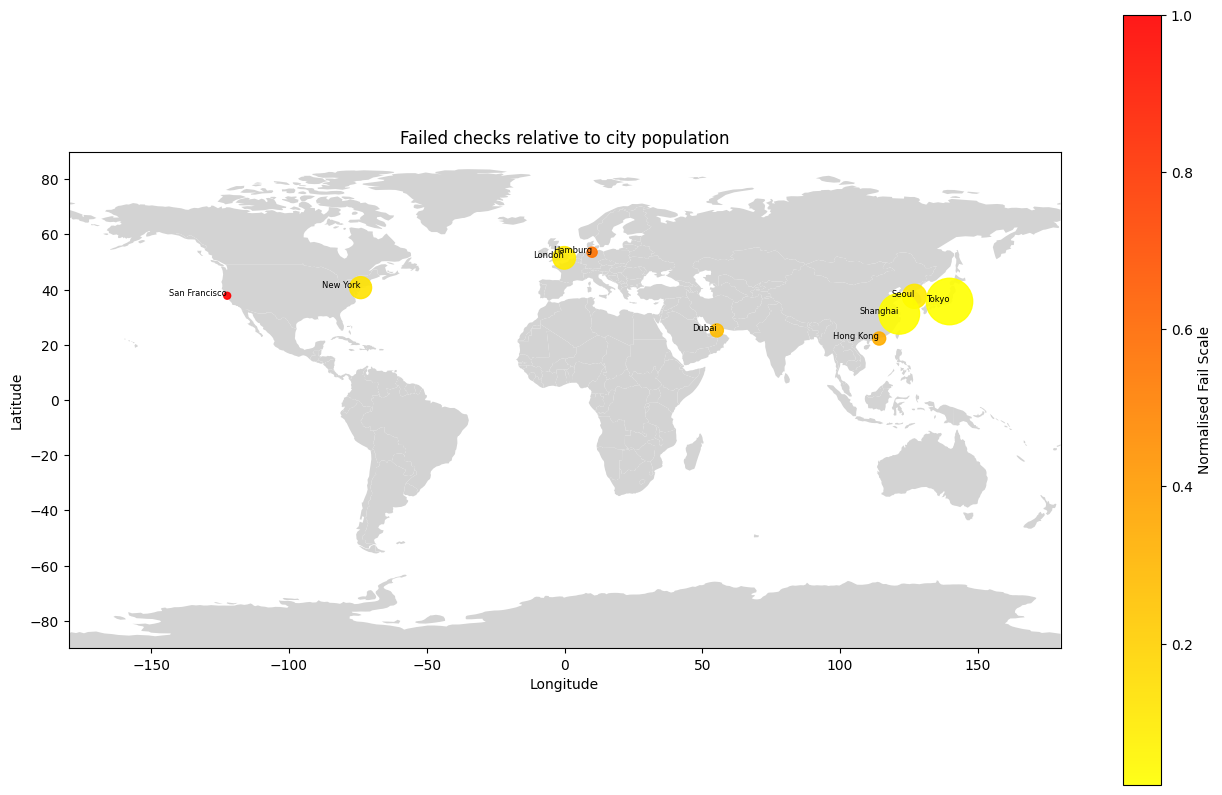

In [ ]:
import geopandas
worldmap = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)
x = geo_df['Longitude']
y = geo_df['Latitude']
z = fpc['fail_pct']
p = fpc['pop']
l = geo_df['Location']

plt.scatter(x, y,
            s = p * 0.00003,
            c = z/p / max(z/p), # fail : pop ratio
            cmap = 'autumn_r',
            #label = geo_df['city'],
            alpha = 0.9
)
plt.colorbar(label='Normalised Fail Scale')

for i in range(0,len(geo_data)):
  plt.text(geo_df.iloc[i][2],geo_df.iloc[i][1],geo_df.iloc[i][0],fontsize=6, ha='right')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.title("Failed checks relative to city population")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Do a cute pie chart to highlight fail rate per city.

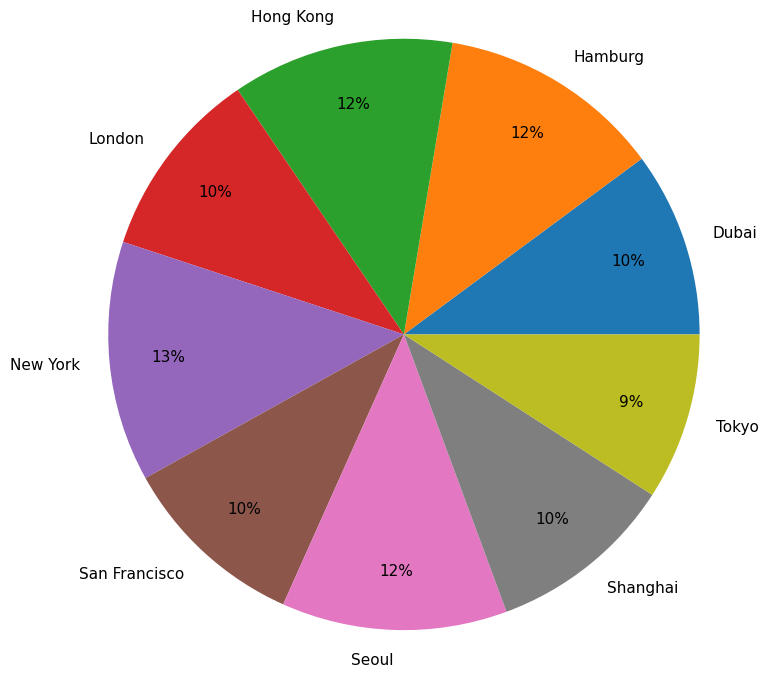

In [ ]:
plt.pie(z, labels = geo_df['Location'],autopct='%1.0f%%', pctdistance=0.8, labeldistance=1.1,textprops={'fontsize': 11},radius = 2)
plt.show()

Fail rate per city per population.

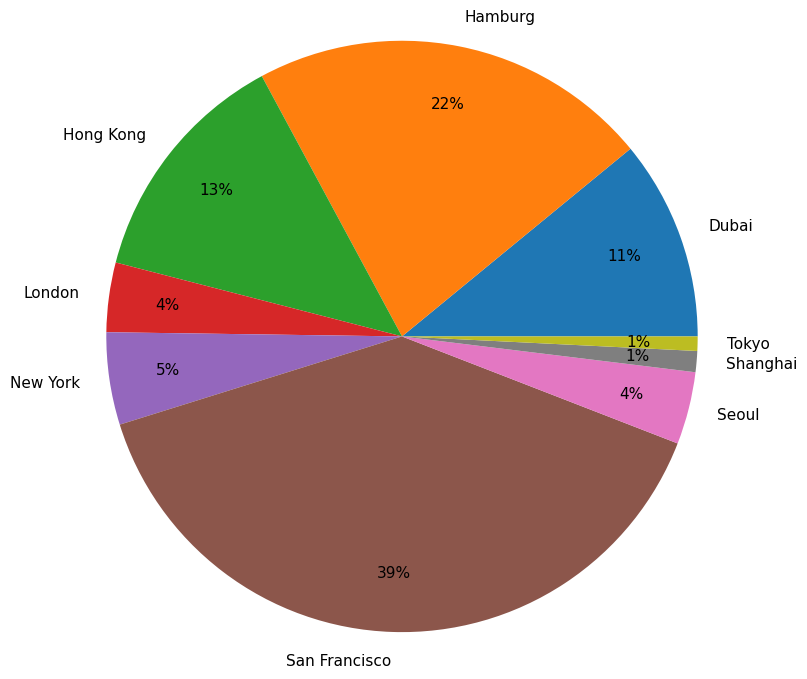

In [ ]:
plt.pie(z/p, labels = geo_df['Location'],autopct='%1.0f%%', pctdistance=0.8, labeldistance=1.1,textprops={'fontsize': 11},radius = 2)
plt.show()

Suggestion:
- Investigate San Francisco
- Would be handy to have number of successes per country

### Fails per City per Month

In [ ]:
fpcpm = pd.DataFrame()
for i in tuple(fpc['Location']):
  #print(i)
  fpcpm[i] = failed_df.loc[failed_df['Location'] == i].groupby(failed_df['month_year'], axis = 0).count().rename(columns={"month_year":i}).drop("Location",axis = 1)
fpcpm = fpcpm.reset_index()
fpcpm

,month_year,Dubai,Hamburg,Hong Kong,London,New York,San Francisco,Seoul,Shanghai,Tokyo
0,2022-01,7,11,15,9,10,8,8,8,7
1,2022-02,8,8,10,9,14,6,8,8,4
2,2022-03,9,18,8,12,9,6,12,12,7
3,2022-04,11,7,11,8,9,9,9,5,8
4,2022-05,6,11,10,5,14,16,6,14,7
5,2022-06,5,11,12,9,7,8,10,5,7
6,2022-07,12,9,9,13,15,12,7,9,11
7,2022-08,10,5,7,8,18,8,12,8,13
8,2022-09,9,11,13,11,7,10,14,7,5
9,2022-10,9,11,8,6,14,6,8,7,8


In [ ]:
fpcpm['Average'] = 0
for city in tuple(fpc['Location']):
  fpcpm['Average'] = fpcpm['Average'] + fpcpm[city]
fpcpm['Average'] = round(fpcpm['Average']/9,2)
fpcpm

,month_year,Dubai,Hamburg,Hong Kong,London,New York,San Francisco,Seoul,Shanghai,Tokyo,Average
0,2022-01,7,11,15,9,10,8,8,8,7,9.22
1,2022-02,8,8,10,9,14,6,8,8,4,8.33
2,2022-03,9,18,8,12,9,6,12,12,7,10.33
3,2022-04,11,7,11,8,9,9,9,5,8,8.56
4,2022-05,6,11,10,5,14,16,6,14,7,9.89
5,2022-06,5,11,12,9,7,8,10,5,7,8.22
6,2022-07,12,9,9,13,15,12,7,9,11,10.78
7,2022-08,10,5,7,8,18,8,12,8,13,9.89
8,2022-09,9,11,13,11,7,10,14,7,5,9.67
9,2022-10,9,11,8,6,14,6,8,7,8,8.56


Let's plot this data to see if there are any trends.

In [ ]:
#plt.figure(figsize=(25,15), dpi=80)
#for city in tuple(fpc['Location']):
#  plt.plot((fpcpm['month_year'].dt.month),fpcpm[city],label=city)
#plt.title("Failed checks per country per month")
#plt.xlabel("Month")
#plt.ylabel("Failed checks")
#plt.legend()

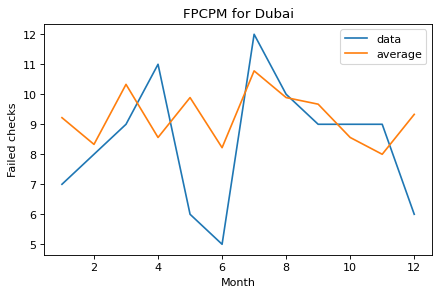

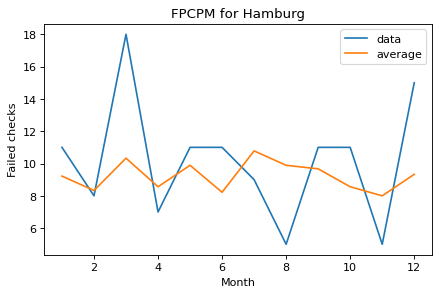

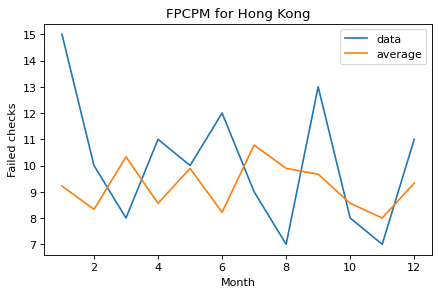

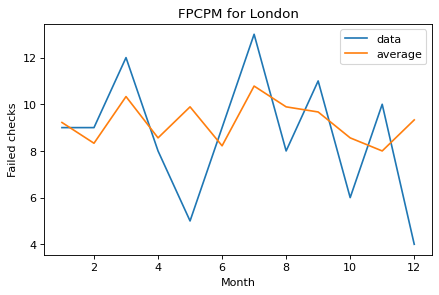

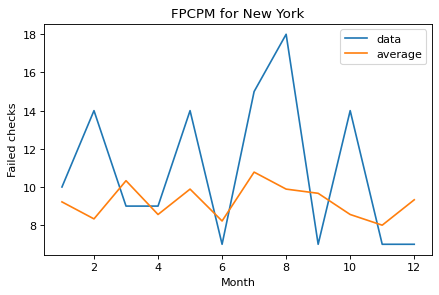

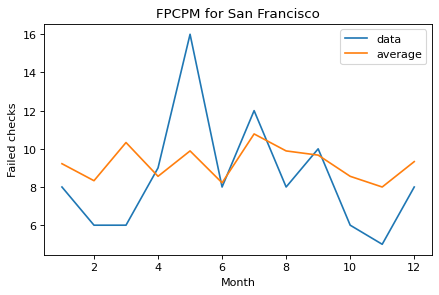

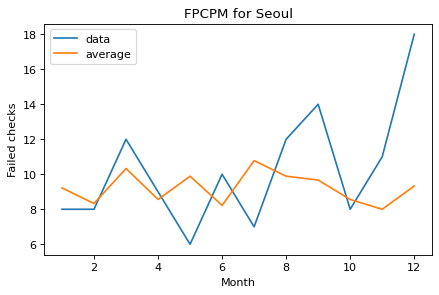

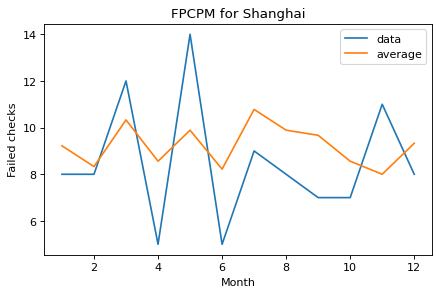

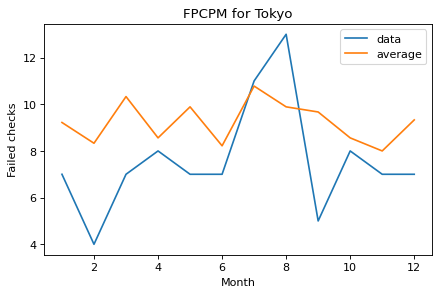

In [ ]:
for city in tuple(fpc['Location']):
  plt.figure(figsize=(6.25,3.75), dpi=80)
  plt.plot((fpcpm['month_year'].dt.month),fpcpm[city], label = 'data')
  plt.plot((fpcpm['month_year'].dt.month),fpcpm['Average'], label = 'average')
  plt.title("FPCPM for " + city)
  plt.xlabel("Month")
  plt.ylabel("Failed checks")
  plt.legend()

Let's have a look at the data distributions per city.

In [ ]:
fpcpm

,month_year,Dubai,Hamburg,Hong Kong,London,New York,San Francisco,Seoul,Shanghai,Tokyo
0,2022-01,7,11,15,9,10,8,8,8,7
1,2022-02,8,8,10,9,14,6,8,8,4
2,2022-03,9,18,8,12,9,6,12,12,7
3,2022-04,11,7,11,8,9,9,9,5,8
4,2022-05,6,11,10,5,14,16,6,14,7
5,2022-06,5,11,12,9,7,8,10,5,7
6,2022-07,12,9,9,13,15,12,7,9,11
7,2022-08,10,5,7,8,18,8,12,8,13
8,2022-09,9,11,13,11,7,10,14,7,5
9,2022-10,9,11,8,6,14,6,8,7,8


In [ ]:
fpcpm.describe()

,Dubai,Hamburg,Hong Kong,London,New York,San Francisco,Seoul,Shanghai,Tokyo
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,8.416667,10.166667,10.083333,8.666667,10.916667,8.500000,10.250000,8.500000,7.583333
std,2.108784,3.785939,2.466441,2.708013,3.872005,3.060006,3.387812,2.679891,2.391589
min,5.000000,5.000000,7.000000,4.000000,7.000000,5.000000,6.000000,5.000000,4.000000
25%,6.750000,7.750000,8.000000,7.500000,7.000000,6.000000,8.000000,7.000000,7.000000
50%,9.000000,11.000000,10.000000,9.000000,9.500000,8.000000,9.500000,8.000000,7.000000
75%,9.250000,11.000000,11.250000,10.250000,14.000000,9.250000,12.000000,9.500000,8.000000
max,12.000000,18.000000,15.000000,13.000000,18.000000,16.000000,18.000000,14.000000,13.000000


<Axes: >

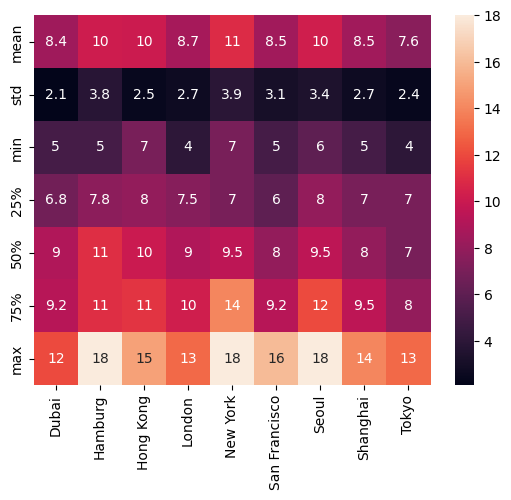

In [ ]:
sns.heatmap(fpcpm.describe().drop('count',axis=0),annot=True)

In [ ]:
for city in tuple(fpc['Location']):
  plt.figure(figsize=(3,3), dpi=80)
  sns.distplot(fpcpm[city])
  plt.axvline(x=np.mean(fpcpm[city]), c='red',ls='--',label = 'mean')
  plt.axvline(x=np.percentile(fpcpm[city],25),c='green',ls='--', label = '25-75th percentile')
  plt.axvline(x=np.percentile(fpcpm[city],75),c='green',ls='--')
  plt.legend()

  #plt.title("FPCPM for " + city)
  #plt.xlabel("Month")
  #plt.ylabel("Failed checks")

## Data Insights

In [ ]:
fpcpm

,month_year,Dubai,Hamburg,Hong Kong,London,New York,San Francisco,Seoul,Shanghai,Tokyo,Average
0,2022-01,7,11,15,9,10,8,8,8,7,9.22
1,2022-02,8,8,10,9,14,6,8,8,4,8.33
2,2022-03,9,18,8,12,9,6,12,12,7,10.33
3,2022-04,11,7,11,8,9,9,9,5,8,8.56
4,2022-05,6,11,10,5,14,16,6,14,7,9.89
5,2022-06,5,11,12,9,7,8,10,5,7,8.22
6,2022-07,12,9,9,13,15,12,7,9,11,10.78
7,2022-08,10,5,7,8,18,8,12,8,13,9.89
8,2022-09,9,11,13,11,7,10,14,7,5,9.67
9,2022-10,9,11,8,6,14,6,8,7,8,8.56


<Axes: >

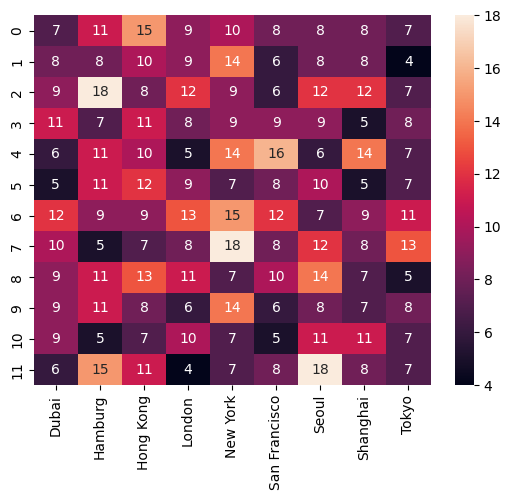

In [ ]:
fpcpm2 = fpcpm.drop('month_year',axis=1).drop('Average',axis=1)

sns.heatmap(fpcpm2,annot=True)